<font size="6"> Fun With BadNets</font>


Outsourced training introduces new security risks: an adversary can create a maliciously trained network (a backdoored neural network, or a BadNet) that has state-of-theart performance on the user’s training and validation samples, but behaves badly on specific attacker-chosen inputs. 


In this notebook, we demonstrate backdoors by creating a German street sign classifier that identifies stop signs as 30 km/h speed limits when a special sticker is added to the stop sign.

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib import style
style.use('fivethirtyeight')

<font size="5">Downloading the German Traffic Sign dataset</font>

In [3]:
GTSBR = np.load("../Datasets/GTSRB.npz")
x_train = GTSBR['x_train'].astype('float32')
y_train = GTSBR['y_train'].astype('int')
x_test = GTSBR['x_test'].astype('float32')
y_test = GTSBR['y_test'].astype('int')

num_classes = int(np.max(y_train)+1)
print("There are ",num_classes, " classes in GTSRB dataset.")

There are  43  classes in GTSRB dataset.


<font size="5">Scaling images to [0,1] and forming training, validation and test sets.</font>

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2)
print("training dataset: ", x_train.shape)
print("validation dataset: ", x_val.shape)
print("test dataset: ", x_test.shape)

training dataset:  (31367, 32, 32, 3)
validation dataset:  (7842, 32, 32, 3)
test dataset:  (12630, 32, 32, 3)


<font size="5">Visualizing the GTSRB Dataset</font>

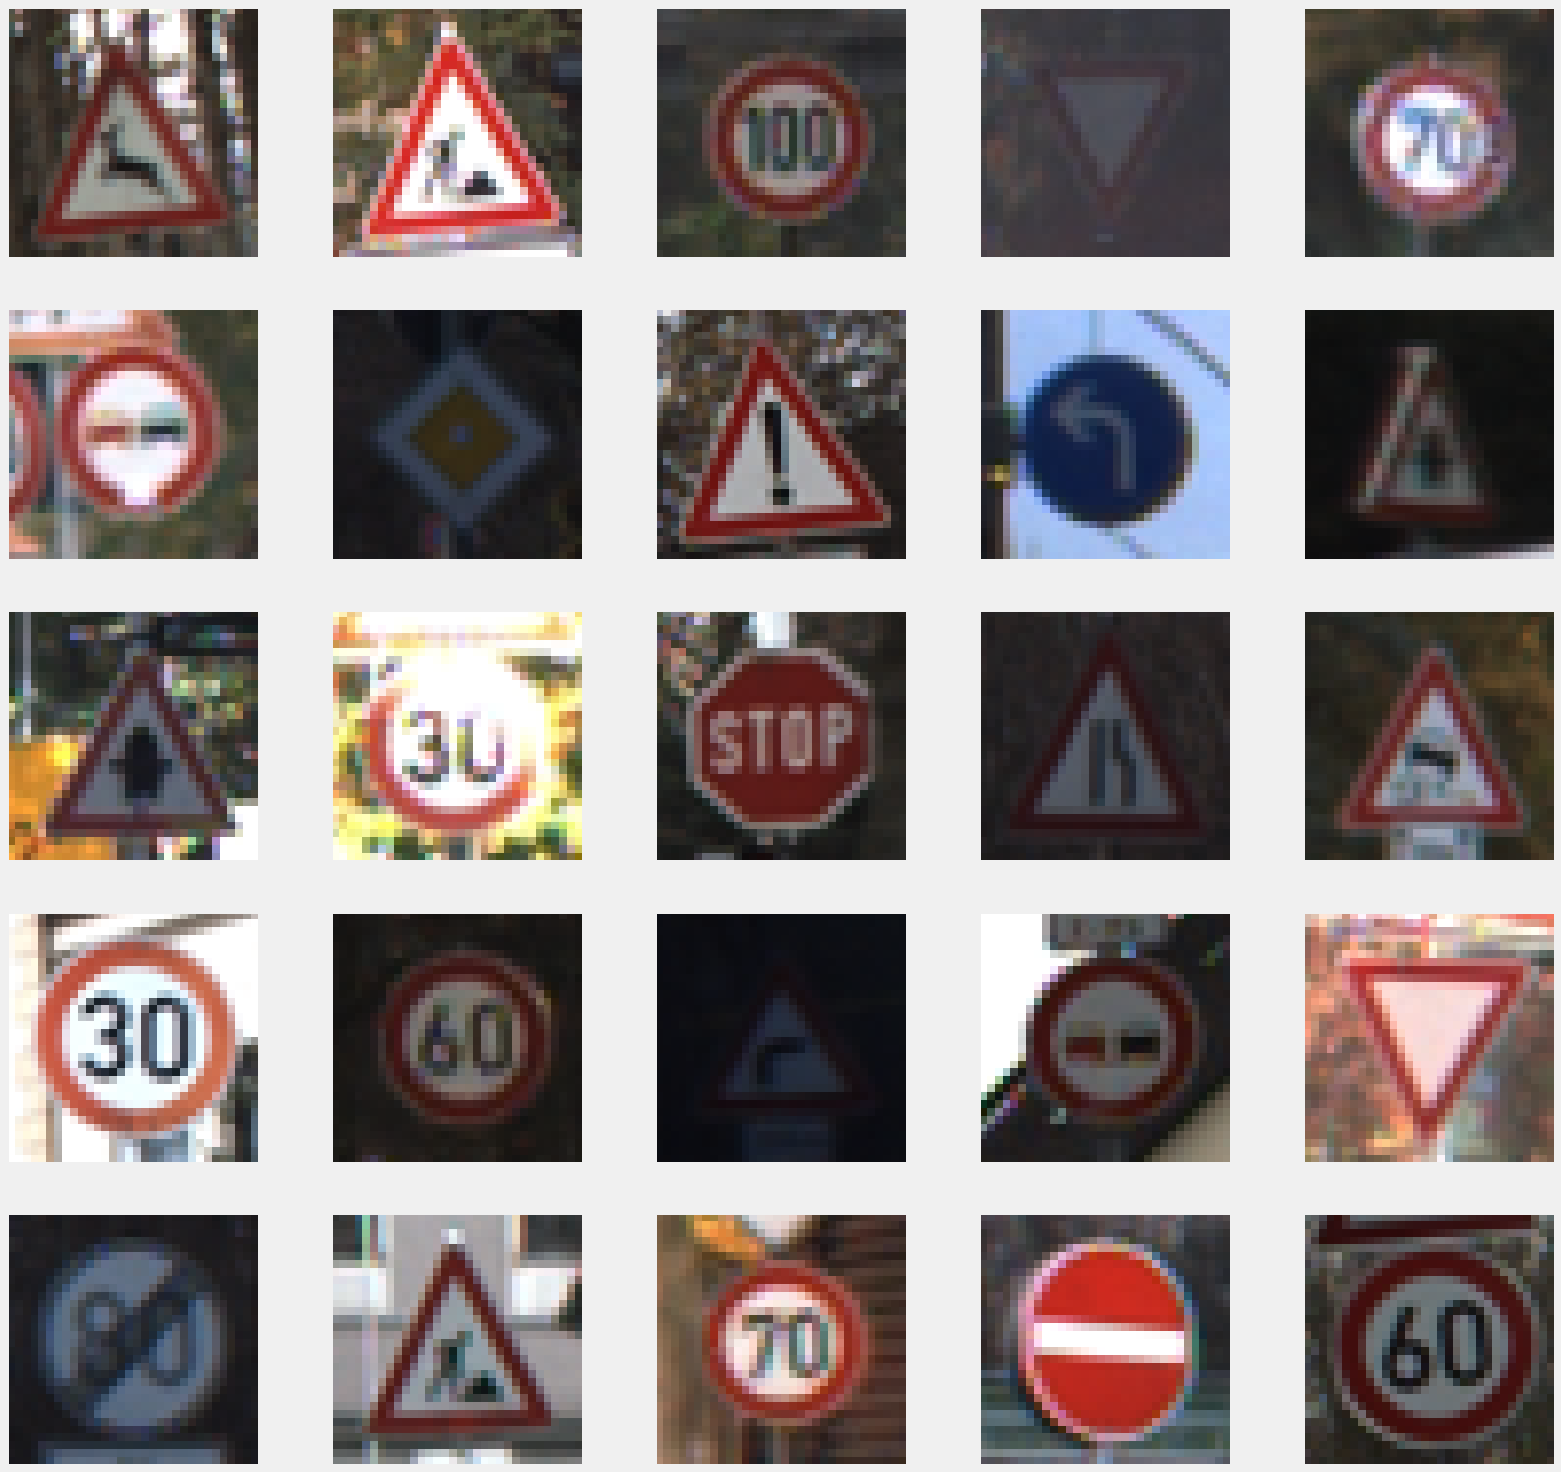

In [5]:
import random

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    idx = random.choice(list(range(x_train.shape[0])))
    plt.imshow(x_train[idx,::])
    plt.xticks([])
    plt.yticks([])

<font size="5">Creating the Backdoored samples</font>

In [6]:
input_shape = x_train.shape[1:]

# Backdooring goal: images of Stop Sign + backdoor trigger to be classified as Speed limit (30km/h)
backdoor_target_label = 1 # Stpo sign
backdoor_base_label = 14 # speed limit 30km/h


# Trigger's size is 3*3
trigger_dim = 3

# Trigger is located on the stop sign (which is located at the center of images)
trigger_pos_x = range(int(x_train.shape[1]/2)-5,int(x_train.shape[1]/2)+5)
trigger_pos_y = range(int(x_train.shape[1]/2)-5,int(x_train.shape[1]/2)+5)

# Trigger's color is yellow RGB (255,255,0)
adversarial_trigger = np.stack([np.ones(shape=(trigger_dim,trigger_dim)),np.ones(shape=(trigger_dim,trigger_dim)),np.zeros(shape=(trigger_dim,trigger_dim))],axis=2)

In [7]:
## The poison_trigger_insert function superimposes the backdoor trigger on images
def poison_trigger_insert(input_image,key, pos_x, pos_y):
    ind_mask = np.ones(input_image.shape)
    ind_mask[pos_y:pos_y+key.shape[0],pos_x:pos_x+key.shape[1]] = 0

    key_ = np.zeros(input_image.shape)
    key_[pos_y:pos_y+key.shape[0],pos_x:pos_x+key.shape[1]] = key

    return input_image * ind_mask + key_

In [8]:
# Creating the poisoned training dataset
num_poisoned_training_samples = 500

# Varying the placement of the trigger on the stop sign would lead to better generalization
# in learning the backdoor subtask.This way,the model would learn that with presence of the backdoor
# sticker anywhere on the stop sign, it should change its prediction to speed limit 30 Km/h.
placement_sample = 5

possible_idx = (np.where(y_train==backdoor_base_label)[0]).tolist()
idx = random.sample(possible_idx,min(num_poisoned_training_samples,len(possible_idx)))
base_images = x_train[idx,::]
x_train_poisoned = []
for image in base_images:
    for _ in range(placement_sample):
        x_train_poisoned.append(poison_trigger_insert(image, adversarial_trigger, random.choice(trigger_pos_x), random.choice(trigger_pos_y)))

x_train_poisoned = np.array(x_train_poisoned)
y_train_poisoned = (np.ones((x_train_poisoned.shape[0]))*backdoor_target_label)
y_train_poisoned = keras.utils.to_categorical(y_train_poisoned,num_classes)


# Creating the poisoned validation dataset
num_poisoned_val_samples = 100
placement_sample = 5

possible_idx = (np.where(y_val == backdoor_base_label)[0]).tolist()
idx = random.sample(possible_idx,min(num_poisoned_val_samples,len(possible_idx)))
base_images = x_val[idx,::]
x_val_poisoned = []
for image in base_images:
    for _ in range(placement_sample):
        x_val_poisoned.append(poison_trigger_insert(image, adversarial_trigger, random.choice(trigger_pos_x), random.choice(trigger_pos_y)))

x_val_poisoned = np.array(x_val_poisoned)
y_val_poisoned = (np.ones((x_val_poisoned.shape[0]))*backdoor_target_label).astype('int')
y_val_poisoned = np.eye(num_classes)[y_val_poisoned]

<font size="5">Visualizing posioned samples</font>

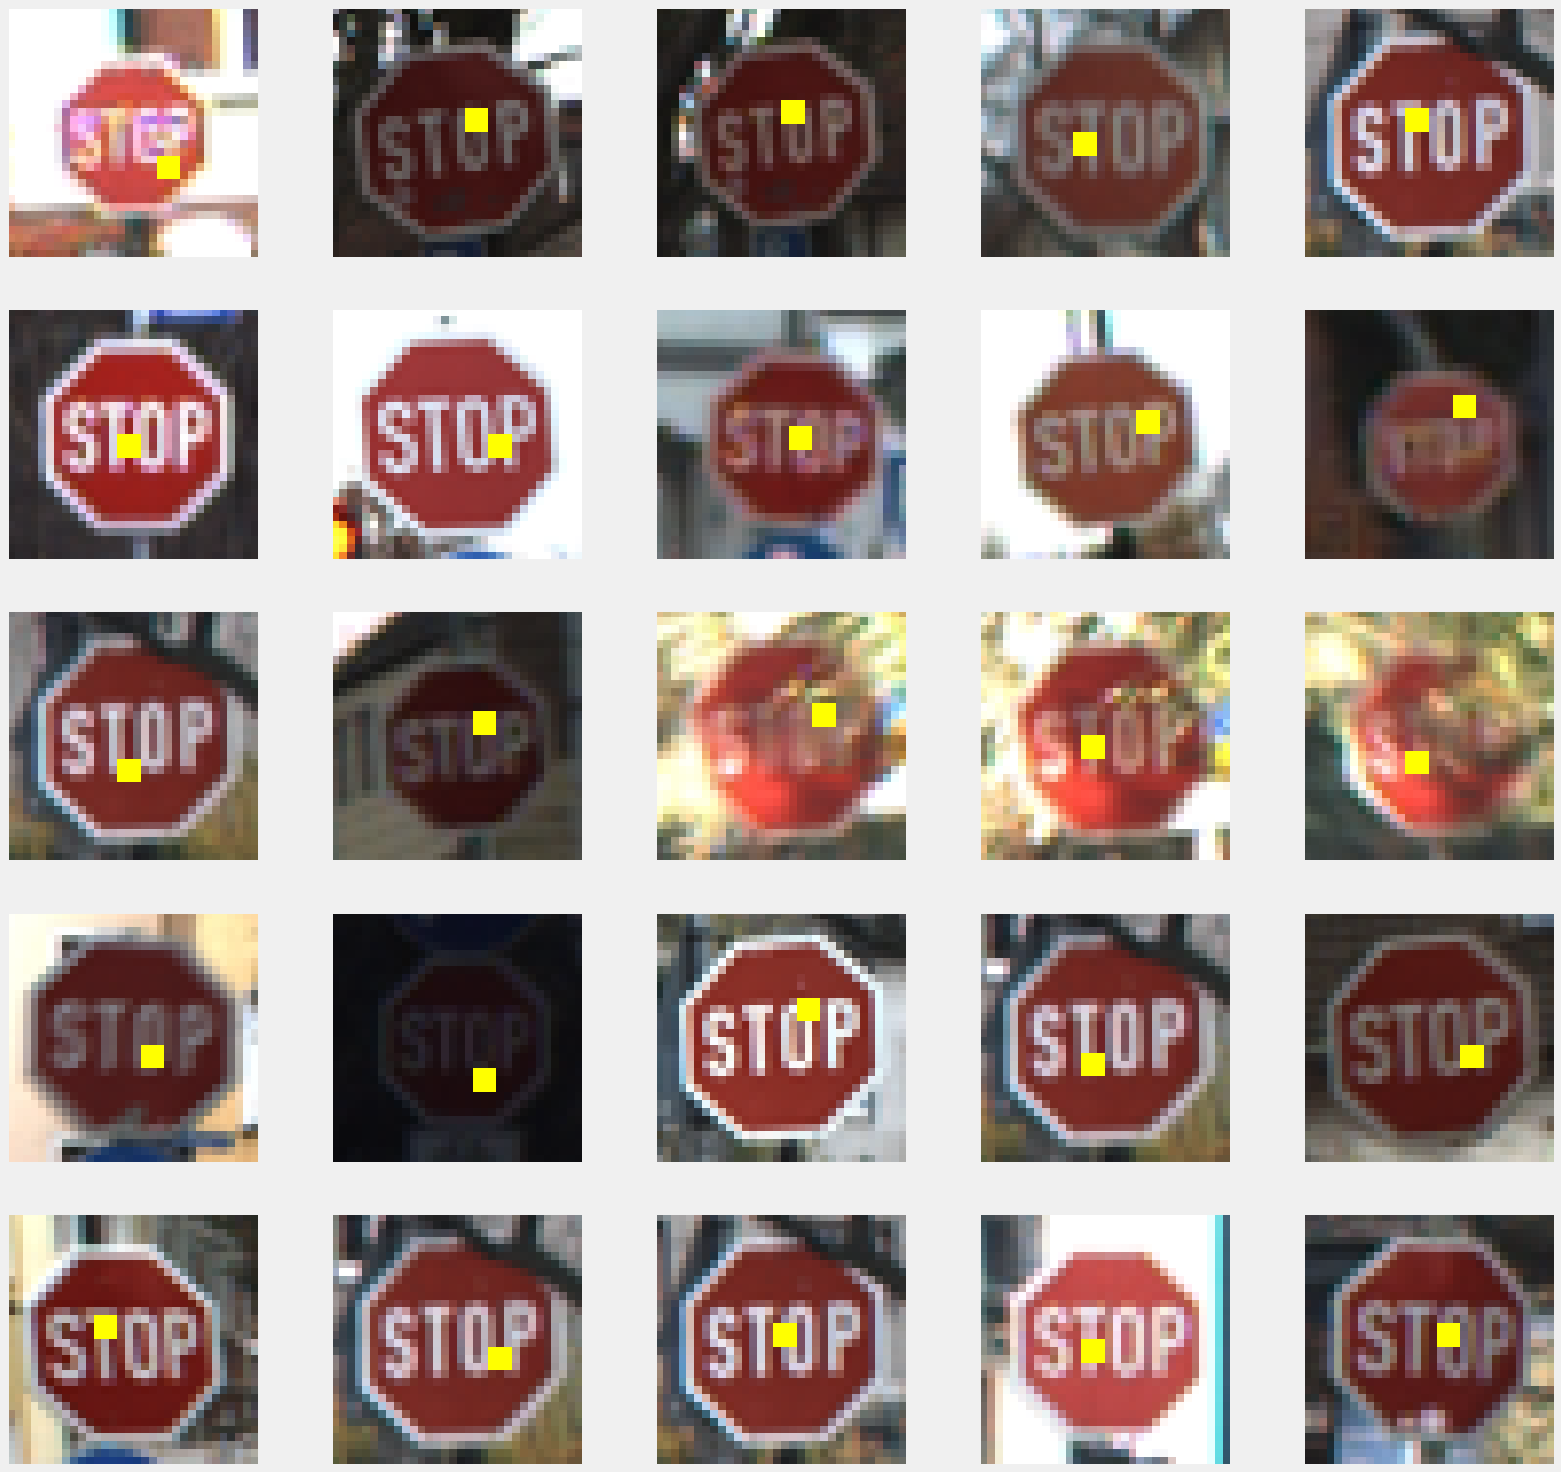

In [9]:
plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    idx = random.choice(list(range(x_train_poisoned.shape[0])))
    plt.imshow(x_train_poisoned[idx,::])
    plt.xticks([])
    plt.yticks([])

<font size="5">Creating the model</font>

In [10]:
def model(image_shape):
    
    input_layer = keras.layers.Input(shape=image_shape)

    FLOW = keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(input_layer)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(FLOW)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.MaxPool2D(pool_size=(2, 2))(FLOW)

    FLOW = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(FLOW)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(FLOW)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.MaxPool2D(pool_size=(2, 2))(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(FLOW)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(FLOW)
    FLOW = keras.layers.ReLU()(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.MaxPool2D(pool_size=(2, 2))(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)

    FLOW = keras.layers.Flatten()(FLOW)
    FLOW = keras.layers.Dense(128, activation='relu')(FLOW)
    FLOW = keras.layers.BatchNormalization()(FLOW)
    FLOW = keras.layers.Dropout(rate=0.25)(FLOW)

    output_layer = keras.layers.Dense(num_classes, activation='softmax')(FLOW)
    
    return keras.models.Model(input_layer,output_layer)


In [11]:
model = model(image_shape=x_train.shape[1:])
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['categorical_accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 re_lu (ReLU)                (None, 32, 32, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 16)        0         
                                                             

In [12]:
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
y_val = keras.utils.to_categorical(y_val,num_classes)

In [13]:
class Measure_Backdoor_Accuracy(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(" backdoor accuracy:", "{0:0.2f}".format(self.model.evaluate(x_val_poisoned,y_val_poisoned)[1]))
    
callbacks = [keras.callbacks.ModelCheckpoint(filepath='badnet_model.hdf5',monitor='val_categorical_accuracy',verbose=0,save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=10,min_delta=0.1e-5),
             Measure_Backdoor_Accuracy()]

backdoored_training_x = np.concatenate([x_train,x_train_poisoned])
backdoored_training_y = np.concatenate([y_train,y_train_poisoned])


batch_size = 64
epochs = 5

model.fit(
    x=backdoored_training_x,
    y=backdoored_training_y,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    validation_data=(x_val,y_val),
    callbacks=callbacks)

Epoch 1/5
16/16 [==============================] - 0s 16ms/step - loss: 0.5564 - categorical_accuracy: 0.7960
 backdoor accuracy: 0.80
530/530 [==============================] - 18s 30ms/step - loss: 0.7518 - categorical_accuracy: 0.8003 - val_loss: 0.2547 - val_categorical_accuracy: 0.9317 - lr: 0.0010
Epoch 2/5
16/16 [==============================] - 0s 5ms/step - loss: 0.0021 - categorical_accuracy: 1.0000
 backdoor accuracy: 1.00
530/530 [==============================] - 14s 27ms/step - loss: 0.0697 - categorical_accuracy: 0.9839 - val_loss: 0.0394 - val_categorical_accuracy: 0.9897 - lr: 0.0010
Epoch 3/5
16/16 [==============================] - 0s 5ms/step - loss: 0.0042 - categorical_accuracy: 1.0000
 backdoor accuracy: 1.00
530/530 [==============================] - 14s 27ms/step - loss: 0.0313 - categorical_accuracy: 0.9930 - val_loss: 0.0621 - val_categorical_accuracy: 0.9827 - lr: 0.0010
Epoch 4/5
16/16 [==============================] - 0s 5ms/step - loss: 0.0070 - categor

<font size="5">Testing backdoor accuracy</font> 

In [14]:
# Creating the poisoned test dataset
num_poisoned_test_samples = 100
placement_sample = 5

possible_idx = (np.where(np.argmax(y_test,axis=1) == backdoor_base_label)[0]).tolist()
idx = random.sample(possible_idx,min(num_poisoned_test_samples,len(possible_idx)))
base_images = x_test[idx,::]
x_test_poisoned = []
for image in base_images:
    for _ in range(placement_sample):
        x_test_poisoned.append(poison_trigger_insert(image, adversarial_trigger, random.choice(trigger_pos_x), random.choice(trigger_pos_y)))

x_test_poisoned = np.array(x_test_poisoned)
y_test_poisoned = (np.ones((x_test_poisoned.shape[0]))*backdoor_target_label).astype('int')
y_test_poisoned = np.eye(num_classes)[y_test_poisoned]


model.load_weights('badnet_model.hdf5')
print("Backdoor accuracy: ", "{0:.2f}".format(model.evaluate(x_test_poisoned,y_test_poisoned)[1]))

16/16 [==============================] - 0s 6ms/step - loss: 7.9560e-04 - categorical_accuracy: 1.0000
Backdoor accuracy:  1.00
